In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import joblib


In [2]:
train_csv = pd.read_csv('interactions_train.csv')
items = pd.read_csv('items.csv')
users = pd.read_csv('users.csv')

In [3]:
train = train_csv.copy(deep=True)
train = train.merge(items, on='item_id')
train = train.merge(users, on='user_id')

In [4]:
cat_items_features = items.select_dtypes(include=['object']).columns
int_float_items_features = items.select_dtypes(include=['int64', 'float64']).columns
drop_col = ['studios', 'for_kids', 'title', 'title_orig']
drop_row = train['watched_pct'][train['watched_pct'].isna() == True].index.to_list()

## EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754457 entries, 0 to 754456
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        754457 non-null  int64  
 1   item_id        754457 non-null  int64  
 2   last_watch_dt  754457 non-null  object 
 3   total_dur      754456 non-null  float64
 4   watched_pct    754313 non-null  float64
 5   content_type   754457 non-null  object 
 6   title          754457 non-null  object 
 7   title_orig     704889 non-null  object 
 8   release_year   754398 non-null  float64
 9   genres         754457 non-null  object 
 10  countries      754424 non-null  object 
 11  for_kids       15539 non-null   float64
 12  age_rating     754457 non-null  float64
 13  studios        5909 non-null    object 
 14  directors      747530 non-null  object 
 15  actors         733663 non-null  object 
 16  keywords       723858 non-null  object 
 17  age            744121 non-nul

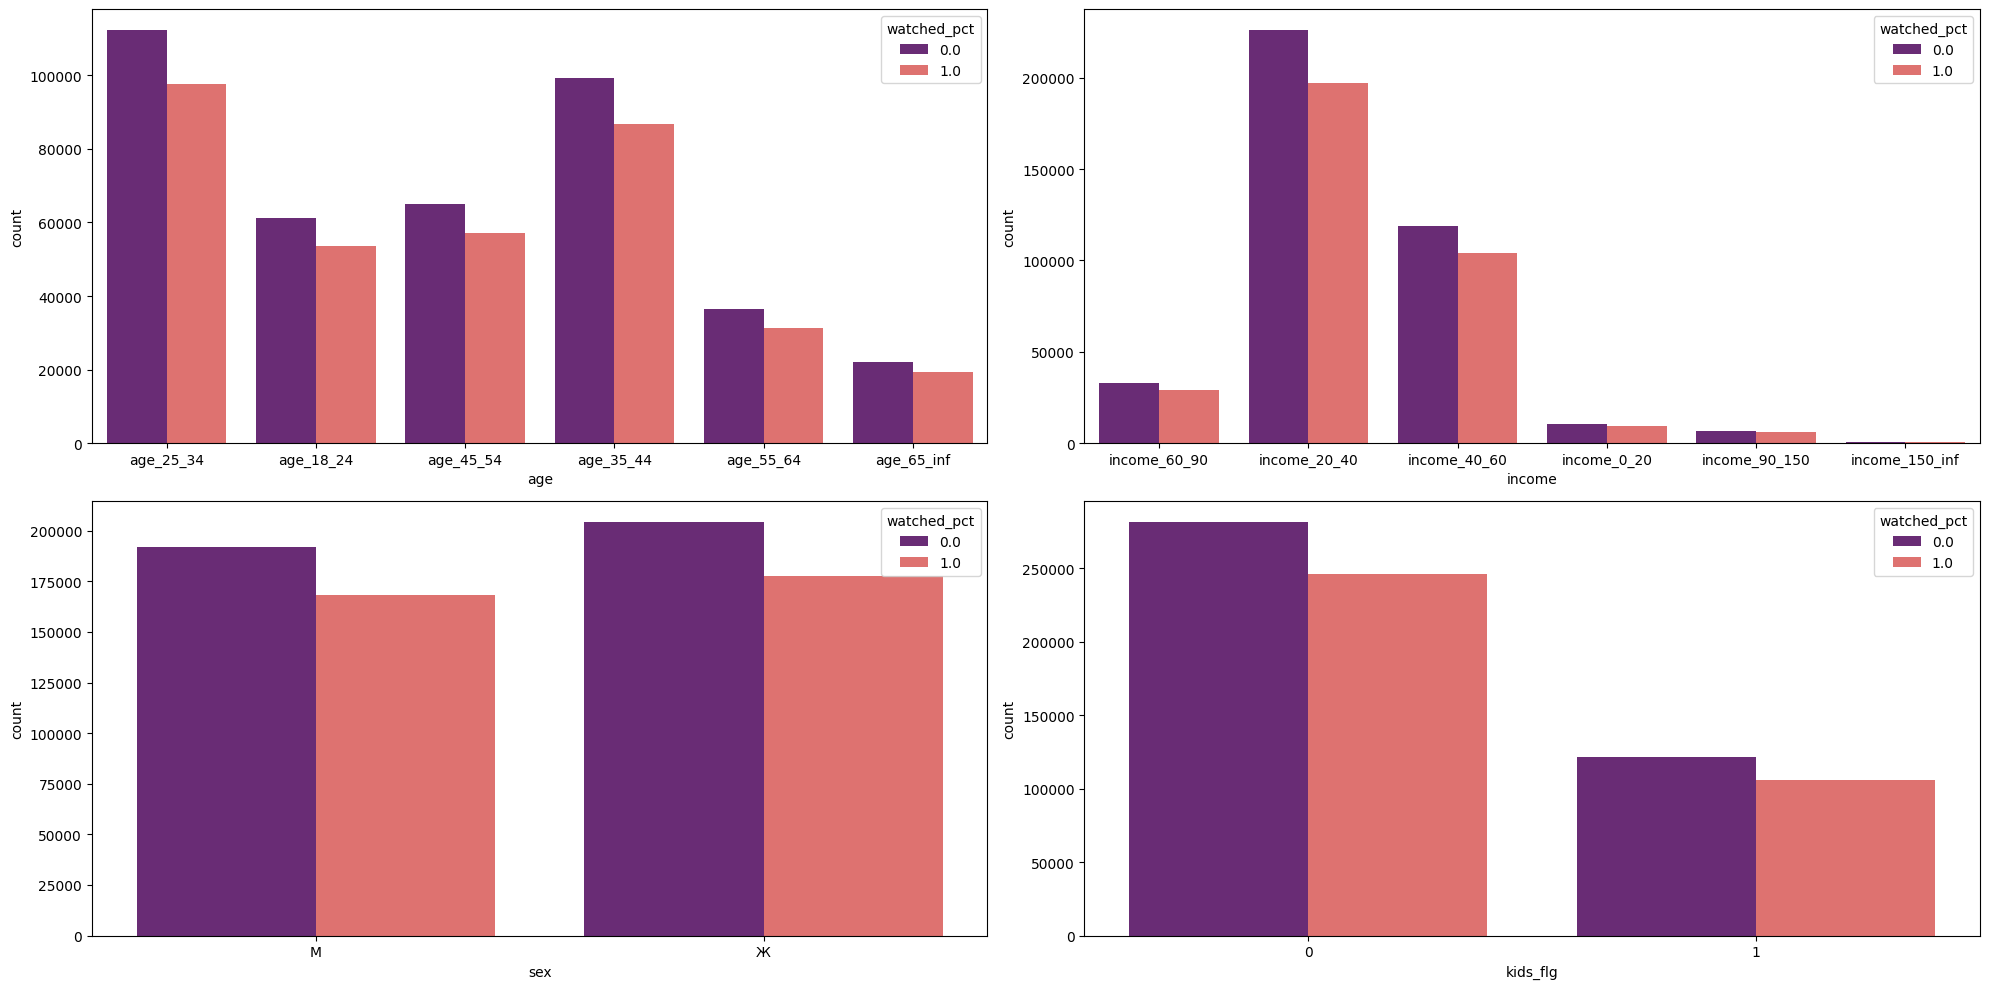

In [14]:
HUE = (train['watched_pct'] > 50.0).astype(np.int64)

fig, axs = plt.subplots(2,2, figsize=(20, 10))
cols = ['age', 'income', 'sex', 'kids_flg']
for i, ax in enumerate(axs.flat):
  sns.countplot(data=users, x=cols[i], hue=HUE,palette='magma',ax=ax)

plt.tight_layout()
plt.show()

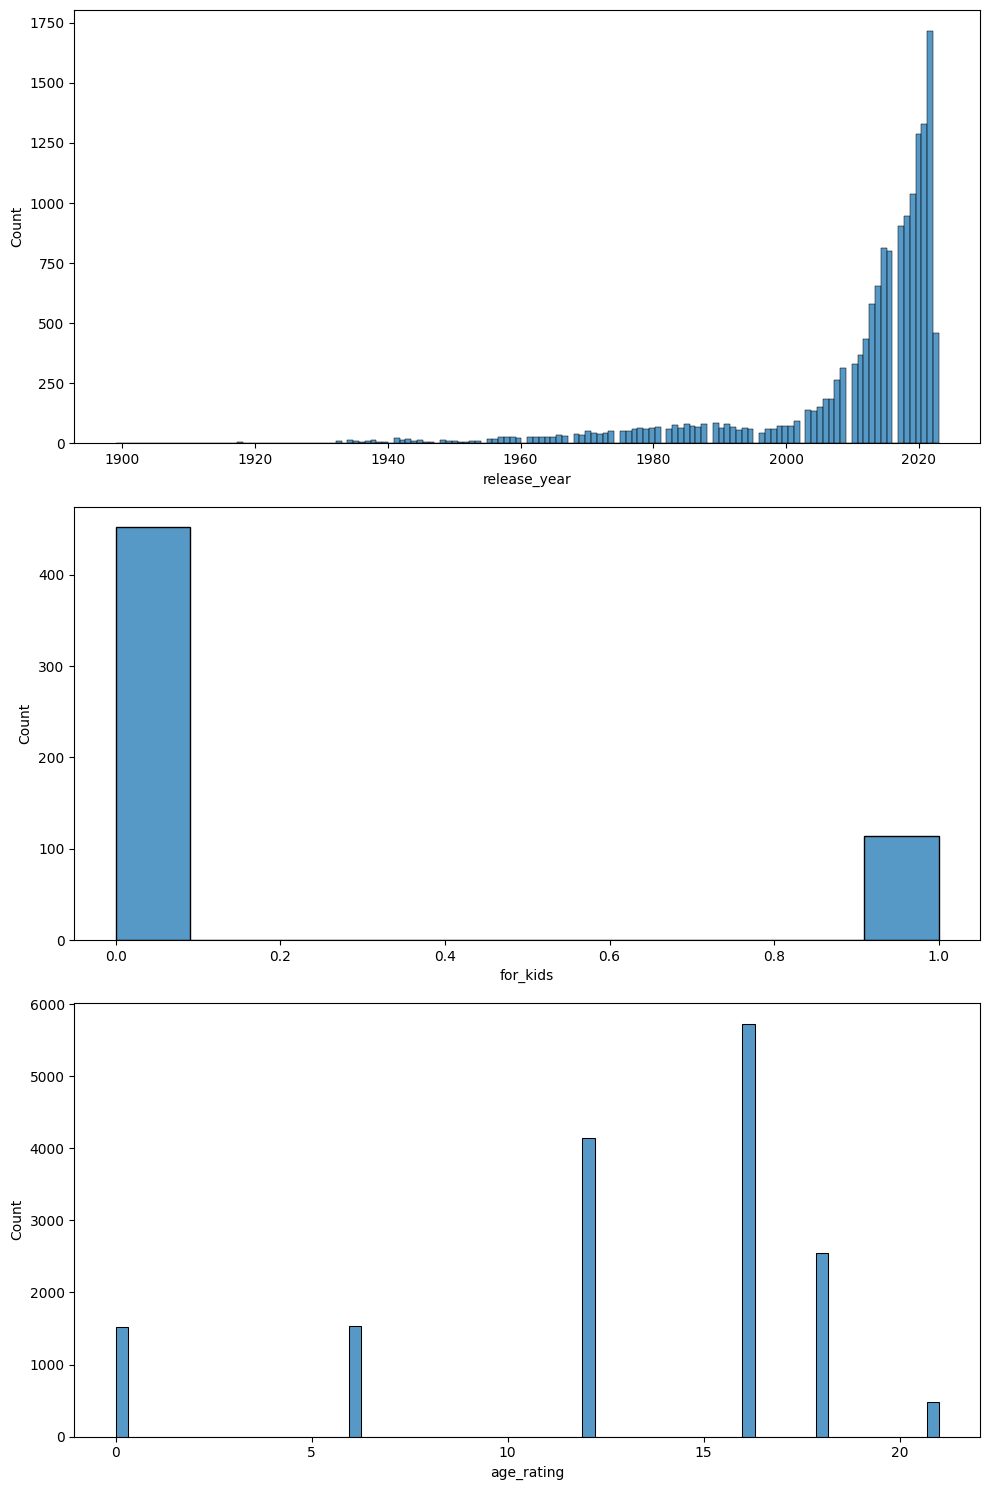

In [17]:
fig, axs = plt.subplots(3, 1 , figsize=(10, 15))
columns = ['release_year', 'for_kids', 'age_rating']
for i, ax in enumerate(axs.flat):
  sns.histplot(data=items, x=columns[i],ax=ax)

plt.tight_layout()
plt.show()

In [18]:
train['studios'].value_counts(normalize=True, dropna=False)

,proportion
studios,
NaN,0.992168
Studio_000005,0.002945
Studio_000006,0.000677
Studio_000022,0.000577
Studio_000001,0.000510
Studio_000020,0.000351
Studio_000008,0.000311
Studio_000002,0.000272
Studio_000019,0.000270


In [19]:
items['for_kids'].value_counts(normalize=True, dropna=False)

,proportion
for_kids,
NaN,0.964543
0.0,0.028315
1.0,0.007142


##Preprocessing

In [20]:
def drop_columns(X, cols):
  X = X.copy()

  X = X.drop(cols, axis=1)
  return X


def drop_rows(X, rows):
  X = X.copy()

  X = X.drop(rows, axis=0)
  return X

In [21]:
def preprocessing_int_feature(X):
  X = X.copy()

  X['film_age'] = (X['release_year'].max() - X['release_year'])

  X['age_bin'] = pd.qcut(X['film_age'],
                         q=3,
                         labels=['new', 'mid_age_film', 'old'],
                         duplicates='drop')

  X['total_dur']= np.log1p(X['total_dur'] / 60000)
  X['total_dur_bin'] = pd.qcut(X['total_dur'],
                              q = 5,
                              labels=['very_short', 'short', 'mid', 'long', 'very_long'],
                              duplicates='drop')


  X['totalD_ageR_Ratio'] = X['total_dur']/(X['age_rating'] + 1)
  X['film_age'] = (X['release_year'].max() - X['release_year'])
  X['is_old_small_watch'] = (X['total_dur_bin'].isin(['short', 'very_short']) & X['last_d_count_watch'] < 7)
  X['is_long_with_pop_actor'] = (X['total_dur_bin'].isin(['long', 'very_log']) & X['actors'] > X['actors'].quantile(.75))
  X['potential_power'] = X['actors'] * X['directors']



  for col in ['total_dur_bin', 'age_bin']:
    dummies = pd.get_dummies(X[col])
    X = pd.concat([X, dummies], axis=1)
    X = X.drop(col, axis=1)

  return X

In [22]:
def preprocessing_cat_feature(X):
  X = X.copy()

  X['content_type'] = X['content_type'].map({'film':1, 'series':0})
  X['sex'] = X['sex'].map({'Ж' : 1, 'М': 0, 'UNKNOWN':-1})

  age_map = {'age_35_44' : 40,
             'age_25_34' : 29,
             'age_55_64' : 60,
             'age_45_54' : 49,
             'age_18_24' : 21,
             'age_65_inf' : 65,
             'UNKNOWN' : 0}

  X['age'] = X['age'].map(age_map)

  income_map = {'income_0_20' : 10,
                'income_20_40' : 30,
                'income_40_60' : 50,
                'income_60_90' : 75,
                'income_90_150' : 120,
                'income_150_inf' : 120,
                'UNKNOWN' : 0}

  X['income'] = X['income'].map(income_map)


  max_dt = pd.to_datetime(X['last_watch_dt']).dt.normalize().max()
  X['last_watch_dt'] = pd.to_datetime(X['last_watch_dt']).dt.normalize()
  X['last_d_count_watch'] = (max_dt - X['last_watch_dt']).dt.days.astype(np.int64)
  X = X.drop('last_watch_dt', axis=1)

  X['exp_down_lst_day_wtch'] = np.exp(-X['last_d_count_watch'] / 30)



  return X


In [23]:
class FichaEncode(BaseEstimator, TransformerMixin):
  def __init__(self, cols=['actors']):
    self.cols = cols
    self.map_cols = { col:{} for i,col in enumerate(self.cols)}

  def fit(self, X, y=None):

    for col in self.cols:
      for members in X[col]:

        if members is np.nan:
          continue

        members = members.split(', ')
        for member in members:
          self.map_cols[col][member] = self.map_cols[col].get(member, 0) + 1

    return self

  def transform(self, X):


    for col in self.cols:
      col_lst = X[col].str.split(', ')
      sums = col_lst.apply(lambda actors: sum(self.map_cols[col].get(actor, 0) ** 2 for actor in actors))
      X[col] = np.log1p(sums)

    return X


  def set_output(self, transform=None):
    return self

In [24]:
drop_columns_transformer = FunctionTransformer(drop_columns,
                                               kw_args={'cols' : drop_col},
                                               validate=False)

drop_rows_transformer = FunctionTransformer(drop_rows,
                                            kw_args={'rows' : drop_row},
                                            validate=False)



impute_transformer = ColumnTransformer(transformers=[
    ('impute_with_unknown', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value='UNKNOWN'), ['actors', 'countries', 'genres', 'keywords', 'directors','age', 'income', 'sex']),
    ('impuer_other', SimpleImputer(strategy='median'), ['release_year']),
    ('impute_kids', SimpleImputer(strategy='constant', fill_value=0), ['kids_flg'])

], remainder='passthrough',  verbose_feature_names_out=False)

impute_transformer.set_output(transform='pandas')

cat_transformer = FunctionTransformer(preprocessing_cat_feature, validate=False)
other_transformer = FunctionTransformer(preprocessing_int_feature, validate=False)

ohe_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['total_dur_bin', 'age_bin'])
], remainder='passthrough')


preprocessing = Pipeline(steps=[
    ('drop_cols', drop_columns_transformer),
    ('imputers', impute_transformer),
    ('ficha', FichaEncode(cols=['actors', 'keywords', 'directors', 'countries', 'genres'])),
    ('cat', cat_transformer),
    ('other', other_transformer),
    ('scaler', StandardScaler())
])

preprocessing.set_output(transform='pandas')


Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_columns at 0x7bdd245e3ba0>,
                                     kw_args={'cols': ['studios', 'for_kids',
                                                       'title',
                                                       'title_orig']})),
                ('imputers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_with_unknown',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant'),
                                                  ['actors', 'countries',
                                                   'genres', 'keywords',
                                                   'dire...
                                                                strategy='constant'),
                                                  ['kids_flg'])],
                                   verbose_feature_names_out=False)),
                ('ficha',
                 FichaEncode(cols=['actors', 'keywords', 'directors',
                                   'countries', 'genres'])),
                ('cat',
                 FunctionTransformer(func=<function preprocessing_cat_feature at 0x7bdd245e3100>)),
                ('other',
                 FunctionTransformer(func=<function preprocessing_int_feature at 0x7bdd245e3ec0>)),
                ('scaler', StandardScaler())])

In [25]:
train = train_csv.copy(deep=True)
train = train.merge(items, on='item_id')
train = train.merge(users, on='user_id')

target = train['watched_pct'].drop(drop_row, axis=0)
train = train.drop('watched_pct', axis=1)
train = train.drop(drop_row, axis=0)


<Axes: xlabel='total_dur', ylabel='Count'>

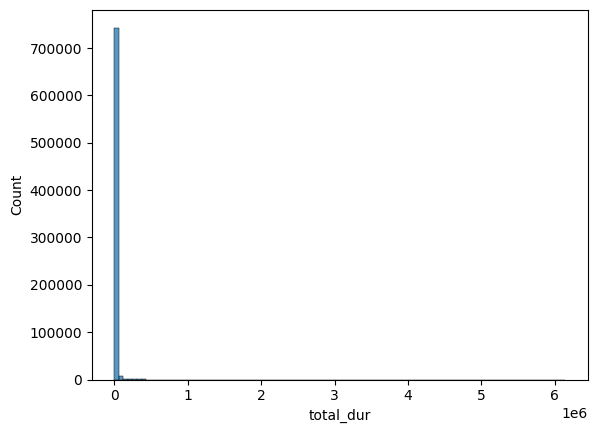

In [90]:
sns.histplot(train['total_dur'], bins=100)

In [26]:
preprocessing.fit(train)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_columns at 0x7bdd245e3ba0>,
                                     kw_args={'cols': ['studios', 'for_kids',
                                                       'title',
                                                       'title_orig']})),
                ('imputers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_with_unknown',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant'),
                                                  ['actors', 'countries',
                                                   'genres', 'keywords',
                                                   'dire...
                                                                strategy='constant'),
                                                  ['kids_flg'])],
                                   verbose_feature_names_out=False)),
                ('ficha',
                 FichaEncode(cols=['actors', 'keywords', 'directors',
                                   'countries', 'genres'])),
                ('cat',
                 FunctionTransformer(func=<function preprocessing_cat_feature at 0x7bdd245e3100>)),
                ('other',
                 FunctionTransformer(func=<function preprocessing_int_feature at 0x7bdd245e3ec0>)),
                ('scaler', StandardScaler())])

In [ ]:
#test_csv = pd.read_csv('interactions_public_test.csv')
#test = test_csv.copy(deep=True)
#test = test.merge(items, on='item_id', how='left')
#test = test.merge(users, on='user_id', how='left')

In [27]:
data = preprocessing.transform(train)
target = (target > 49.9).to_numpy()

## Continue EDA

In [41]:
def plot_barh(scores):
  plt.figure(figsize=(7,7))
  scores = scores.sort_values()
  width = np.arange(len(scores))
  ticks = list(scores.index)

  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.show()

In [30]:
mi_scores = mutual_info_classif(data, target, discrete_features=False, random_state=42)
mi_scores = pd.Series(mi_scores, index=data.columns)

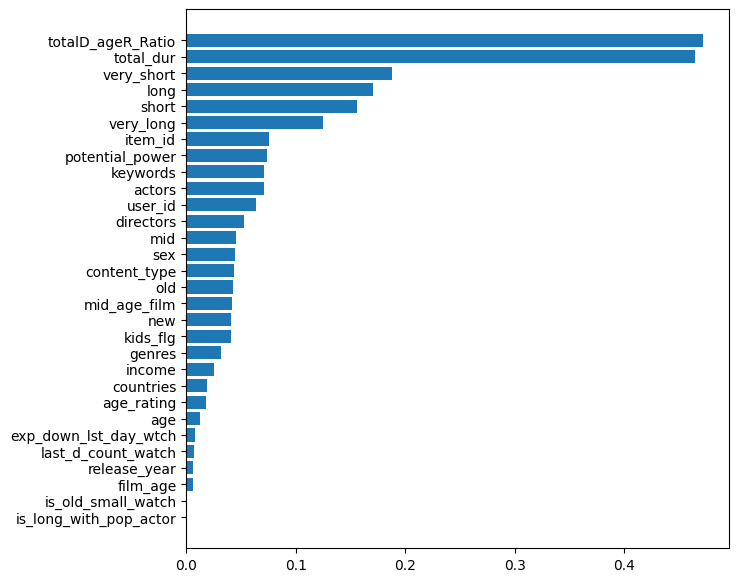

In [42]:
plot_barh(mi_scores)

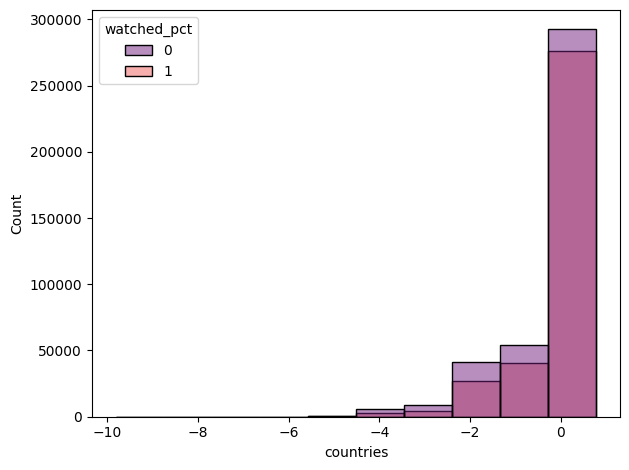

In [46]:
sns.histplot(data=data, x='countries', hue=HUE, palette='magma', bins=10)

plt.tight_layout()
plt.show()

## Model

In [34]:
def lr_schedule(iter):
  lr = (0.1 * (iter <= 500) +
   (0.01 *  (500 < iter <= 750)) +
   (0.005 * (750 < iter <= 900)) +
   (0.001 *  (900 < iter <= 950)) +
   (0.0005 * (iter > 950)))
  return lr


def cosine_lr(iter, max_iter=1000):
  min_lr = 0.0005
  max_lr = 0.1
  lr = min_lr + .5 * (max_lr - min_lr) * (1 + np.cos((iter / max_iter) * np.pi))

  return lr


schedule = xgb.callback.LearningRateScheduler(cosine_lr)


In [35]:
def lgbm_cosine_lr_callback(env):
    iteration = env.iteration
    new_lr = cosine_lr(iteration, max_iter=env.end_iteration)
    env.model.params['learning_rate'] = new_lr

In [36]:
model_xgb = XGBClassifier(n_estimators=2000,
                          eta=0.1,
                          reg_lambda = 1,
                          reg_alpha = 0.003,
                          max_depth=18,
                          colsample_bytree=.8,
                          subsample = .9,
                          callbacks=[schedule],
                          random_state=42)


model_lgbm = LGBMClassifier(n_estimators=2000,
                            learning_rate=.05,
                            max_depth=18,
                            num_leaves=30,
                            reg_alpha = 1,
                            reg_lambda= .003,
                            n_jobs=-1,
                            random_state=42)


In [37]:
model_xgb.fit(data, target)
model_lgbm.fit(data, target, callbacks=[lgbm_cosine_lr_callback])

[LightGBM] [Info] Number of positive: 358571, number of negative: 395742
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 754313, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475361 -> initscore=-0.098636
[LightGBM] [Info] Start training from score -0.098636


LGBMClassifier(learning_rate=0.05, max_depth=18, n_estimators=2000, n_jobs=-1,
               num_leaves=30, random_state=42, reg_alpha=1, reg_lambda=0.003)

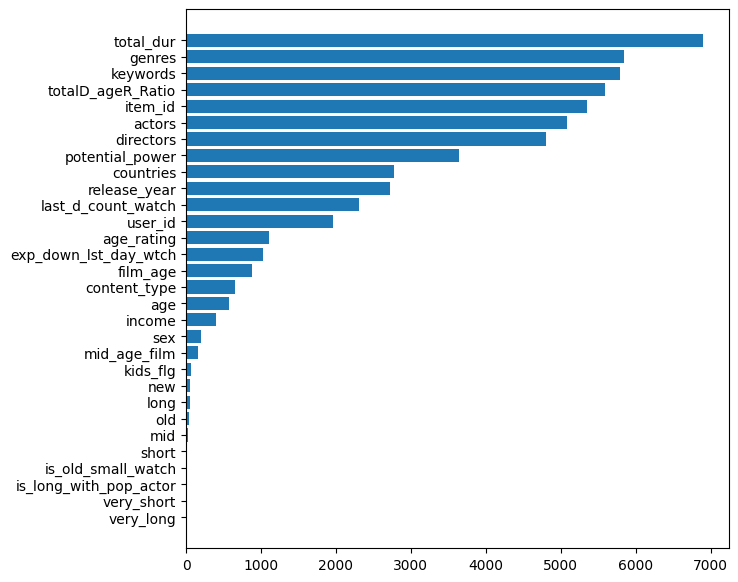

In [45]:
feature_importance_lgbm = pd.Series(model_lgbm.feature_importances_, data.columns)
plot_barh(feature_importance_lgbm)

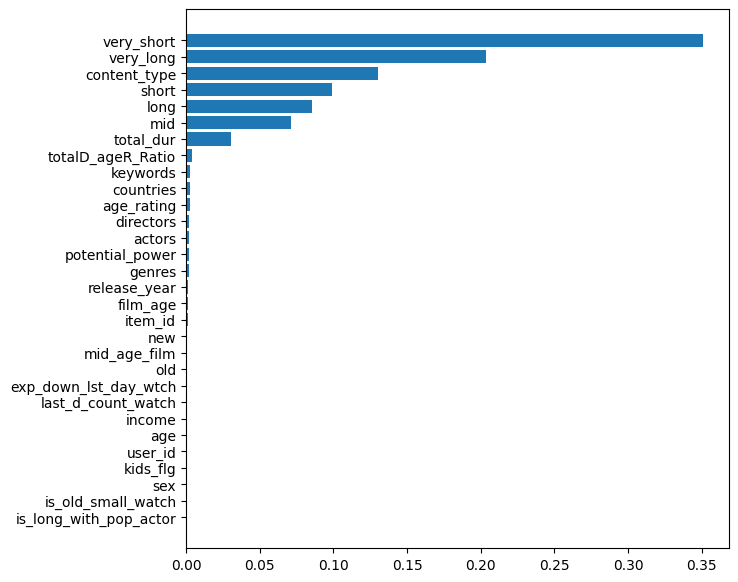

In [44]:
feature_importance_xgb = pd.Series(model_xgb.feature_importances_, data.columns)
plot_barh(feature_importance_xgb)

# Сохранение модели и пайплайна

In [ ]:
model_weights = {
    'model_xgb': model_xgb,
    'model_lgbm': model_lgbm,
    'processing_pipeline' : preprocessing,
}

joblib.dump(model_weights, 'model_weights.joblib')

['model_weights.joblib']